# Experiments

notebook includes experiments using `deepseek-r1-distill-qween-7b`, `o3-mini-2025-01-31`, and `gemini-2.0-flash`

metrics:
- `deepseek-r1-distill-qween-7b`:
    - cost: Free, open sourced running locally
    - rate limits:
        - no rate limits since running locally
        - context length: 4096 tokens per prompt
        - 7B paramter pre trained model

- `o3-mini-2025-01-31`:
    - cost: $1.1 per 1M tokens
    - rate limits:
        - requests per minute: 1,000
        - tokens per minute: 100,000
    - check openai balance: https://platform.openai.com/settings/organization/billing/overview

- `gemini-2.0-flash`:
    - cost: Free tier
    - rate limits:
        - requests per minute: 15
        - tokens per minute: 1,000,000
        - requests per day: 1,500

## Define Run Tests Function

### Define API calls to models

In [1]:
from openai import OpenAI
import requests
from google import genai
import os
import time
import pandas as pd
client = OpenAI()

def gpt(messages=[{
            "role": "user",
            "content": "Write a one-sentence bedtime story about a unicorn."
        }]):
    start_time = time.time()
    
    completion = client.chat.completions.create(
        model="o3-mini-2025-01-31",
        messages=messages
    )
    end_time = time.time()
    elapsed_time = end_time - start_time

    return (completion.choices[0].message.content, elapsed_time)

def gemini(message="Explain how AI works"):
    client = genai.Client(api_key=os.environ["GEMINI_API_KEY"])
    
    start_time = time.time()
    response = client.models.generate_content(
        model="gemini-2.0-flash",
        contents=message,
    )
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    return (response.text, elapsed_time)

def deepseek(messages=[
          { "role": "system", "content": "Always answer in rhymes. Today is Thursday" },
          { "role": "user", "content": "What day is it today?" }
        ]):
    '''
        curl example: 
        curl http://localhost:1234/v1/chat/completions \
          -H "Content-Type: application/json" \
          -d '{
            "model": "deepseek-r1-distill-qwen-7b",
            "messages": [
              { "role": "system", "content": "Always answer in rhymes. Today is Thursday" },
              { "role": "user", "content": "What day is it today?" }
            ],
            "temperature": 0.7,
            "max_tokens": -1,
            "stream": false
        }'
    '''
    request = {
        "model": "deepseek-r1-distill-qwen-7b",
        "messages": messages,
        "temperature": 0.7,
        "max_tokens": -1,
        "stream": False
    }
    
    start_time = time.time()
    response = requests.post('http://localhost:1234/v1/chat/completions', json=request)
    end_time = time.time()
    elapsed_time = end_time - start_time
    
    if response.status_code == 200:
        return (response.json()['choices'][0]['message']['content'], elapsed_time)
    else:
        return (response.text, elapsed_time)

### Run Models Function

In [2]:
def run_gpt(responses, times, p):
    gpt_response = gpt(messages=[{'role': 'user', 'content': p}])
    responses.append(gpt_response[0])
    times.append(gpt_response[1])

def run_models(responses, times, p):
    gpt_response = gpt(messages=[{'role': 'user', 'content': p}])
    responses[0].append(gpt_response[0])
    times[0].append(gpt_response[1])

    deepseek_response = deepseek(messages=[{'role': 'user', 'content': p}])
    responses[1].append(deepseek_response[0])
    times[1].append(deepseek_response[1])

    gemini_response = gemini(message=p)
    responses[2].append(gemini_response[0])
    times[2].append(gemini_response[1])

### Generate Plots Function

In [7]:
from IPython.display import display, Markdown
import pandas as pd
import re

def generate_gpt_table(test_name, prompts, responses, times):
    # init data frame with model response lists
    test_results_df = pd.DataFrame({
        'Prompt': prompts,
        'GPT': responses,
        'GPT Time': times,
    })

    print(f"{test_name} results:")
    display(Markdown(test_results_df.to_markdown()))

def generate_table(test_name, prompts, responses, times):
    # init data frame with model response lists
    test_results_df = pd.DataFrame({
        'Prompt': prompts,
        'GPT': responses[0],
        'GPT Time': times[0],
        'Deepseek': responses[1],
        'Deepseek Time': times[1],
        'Gemini': responses[2],
        'Gemini Time': times[2],
    })
    
    # clean cells, remove think tags from deepseek and remove new lines
    def remove_think_tags(cell):
        if isinstance(cell, str): 
            cell = re.sub(r'<think>.*?</think>', '', cell, flags=re.DOTALL)
            cell = cell.replace('\n', ' ')
        return cell

    # apply filters and render in markdown
    def render_dataframe_as_markdown(df):
        df_cleaned = df.map(remove_think_tags)
        display(Markdown(df_cleaned.to_markdown()))

    print(f"{test_name} results:")
    render_dataframe_as_markdown(test_results_df)

### Wrapped Function

In [8]:
def run_gpt_tests(test_name, prompts):
    responses = []
    times = []
    print(f"gpt o3-mini warming up for {test_name}")
    for p in prompts:
        run_gpt(responses, times, p)
    print(f"gpt inferencing finished for {test_name}")
    generate_gpt_table(test_name, prompts, responses, times)
    return responses, times

def run_tests_e2e(test_name, prompts):
    # ind 0 is gpt, 1 is deepsek, 2 is gemini
    responses = [[],[],[]]
    times = [[],[],[]]
    print(f"models warming up for {test_name}")
    for p in prompts:
        run_models(responses, times, p)
    print(f"models inferencing finished for {test_name}")
    generate_table(test_name, prompts, responses, times)
    return responses, times

## AI explainability and interpretability prompts (White Box)

In [9]:
retrieval_prompts = [
    "How many points did Lebron James score on October 18th, 2018 against the Portland Trailblazers?",
    "How many championships has Steph Curry won in his career?",
    "How many games did Andre Iguodala miss in the 2016-2017 regular season?",
    "What were the top 3 overall teams in terms of standings at the end of the 1996-1997 regular season?"
]

reasoning_prompts = [
    "What do you get if you add Lebron James career point total with Kobe Bryant's career points total?",
    "If you take the Miami Heat's regular season seed standing in the 2013 season compared to their seed in the 2010 season what is the difference?",
    "If you add Micheal Jordan's and Wilt Chamberlain's highest scoring games point total together, what do you get?",
    "How many combined MVP awards do Russell Westbrook and Kareem Abdul-Jabbar have?"
]

long_prompts = [
    '''
    Consider two elite scorers from the 2022-2023 NBA season: Joel Embiid and Luka Dončić. Embiid won the scoring title averaging 33.1 PPG
    on 54.8% FG and 65.5% True Shooting (TS%). Dončić averaged 32.4 PPG on 49.6% FG and 60.9% TS%. Both players had extremely high usage rates,
    dominating the ball for their respective teams, the 76ers and Mavericks. Embiid primarily operated from the post and midrange, while Dončić
    heavily relied on step-back threes and drives. Based purely on the provided PPG and efficiency metrics (FG%, TS%), which player scored more
    efficiently during this season? Briefly explain what TS% tells us compared to just FG% in this context.
    ''',
    '''
    Let's look at the Memphis Grizzlies. In the 2021-2022 season, they finished with the 4th best Offensive Rating (114.3) and 6th best
    Defensive Rating (108.9), playing at the 3rd fastest Pace (101.02). They relied heavily on Ja Morant's drives, offensive rebounding,
    and transition offense. The following season, 2022-2023, their Offensive Rating was 11th (114.7), Defensive Rating improved to 3rd 
    (110.7), and Pace remained high at 3rd (101.33). Despite Morant missing significant time, their defense anchored by Jaren Jackson Jr. 
    became more dominant. Did the Grizzlies become a better overall team based on net rating (Off Rating - Def Rating)? How did their
    identity slightly shift between these two seasons according to these ratings and ranks?
    ''',
    ''' 
    Nikola Jokić finished the 2022-2023 NBA season with a Value Over Replacement Player (VORP) rating of 8.8, leading the league. 
    VORP is an estimate of a player's overall contribution to the team, measured in points per 100 team possessions, translated into 
    wins above what a readily available 'replacement-level' player would provide over the season. Jokić also averaged impressive 
    traditional stats: 24.5 points, 11.8 rebounds, and 9.8 assists per game. How does his league-leading VORP score add context to his 
    traditional stats? What does a VORP of 8.8 specifically suggest about his value to the Denver Nuggets that season?
    ''',
    '''
    In the 2023-2024 season, consider Tyrese Haliburton of the Indiana Pacers and Anthony Davis of the Los Angeles Lakers. Haliburton
    led the league in assists per game (10.9 APG) while scoring 20.1 PPG on efficient shooting splits (47.7% FG / 36.4% 3P / 85.5% FT). 
    Anthony Davis, playing primarily center/power forward, averaged 24.7 PPG, 12.6 RPG (3rd in NBA), and 2.3 BPG (4th in NBA). Both 
    players were critical to their teams' success. Based on these specific stats (PPG, APG, RPG, BPG), contrast the primary roles these
    two All-Stars fulfilled for their respective teams during that season.
    '''
]

# _, retrieval_times = run_tests_e2e("retrieval test", retrieval_prompts)
# _, reasoning_times = run_tests_e2e("reasoning test", reasoning_prompts)
_, retrieval_times = run_gpt_tests("retrival test", retrieval_prompts)
_, reasoning_times = run_gpt_tests("reasoning test", reasoning_prompts)
_, long_times = run_gpt_tests("long prompt test", long_prompts)

gpt o3-mini warming up for retrival test
gpt inferencing finished for retrival test
retrival test results:


|    | Prompt                                                                                              | GPT                                                                                                                                                                                                                                                                       |   GPT Time |
|---:|:----------------------------------------------------------------------------------------------------|:--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|-----------:|
|  0 | How many points did Lebron James score on October 18th, 2018 against the Portland Trailblazers?     | On October 18, 2018, in his debut for the Los Angeles Lakers during the 2018–19 season, LeBron James scored 26 points against the Portland Trail Blazers.                                                                                                                 |   27.7599  |
|    |                                                                                                     |                                                                                                                                                                                                                                                                           |            |
|    |                                                                                                     | In that season-opening game, he also contributed significantly in other statistical categories, recording 11 rebounds and 11 assists to notch a triple‐double. Despite his strong performance, the Lakers ultimately fell short.                                          |            |
|    |                                                                                                     |                                                                                                                                                                                                                                                                           |            |
|    |                                                                                                     | This information is based on the official box score and widely reported recaps from the game.                                                                                                                                                                             |            |
|  1 | How many championships has Steph Curry won in his career?                                           | Steph Curry has won four NBA championships. He secured these titles with the Golden State Warriors in 2015, 2017, 2018, and 2022.                                                                                                                                         |    3.35578 |
|  2 | How many games did Andre Iguodala miss in the 2016-2017 regular season?                             | During the 2016–17 NBA regular season, the Golden State Warriors played 82 games in total, and Iguodala appeared in 77 of them. That means he missed 5 regular‐season games that year.                                                                                    |   21.976   |
|  3 | What were the top 3 overall teams in terms of standings at the end of the 1996-1997 regular season? | Assuming you’re asking about the National Basketball Association’s 1996–97 season, here’s a rundown of the best records from that year:                                                                                                                                   |   16.7752  |
|    |                                                                                                     |                                                                                                                                                                                                                                                                           |            |
|    |                                                                                                     | • The Chicago Bulls finished with a 69–13 record, which was the best in the league.                                                                                                                                                                                       |            |
|    |                                                                                                     |                                                                                                                                                                                                                                                                           |            |
|    |                                                                                                     | • The Utah Jazz ended the season at 64–18, ranking second overall.                                                                                                                                                                                                        |            |
|    |                                                                                                     |                                                                                                                                                                                                                                                                           |            |
|    |                                                                                                     | • In third place, there was a tie: both the Miami Heat and the Seattle SuperSonics finished 61–21, meaning they shared the league’s third-best win–loss percentage.                                                                                                       |            |
|    |                                                                                                     |                                                                                                                                                                                                                                                                           |            |
|    |                                                                                                     | So, if “top 3 overall teams” refers strictly to win–loss records, the Bulls were first, the Jazz second, and the Heat and Sonics tied for third. (Note that when sorting the entire league by record, there wasn’t a single “third” team but rather a tie for that spot.) |            |

gpt o3-mini warming up for reasoning test
gpt inferencing finished for reasoning test
reasoning test results:


|    | Prompt                                                                                                                                         | GPT                                                                                                                                                                                                                                 |   GPT Time |
|---:|:-----------------------------------------------------------------------------------------------------------------------------------------------|:------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|-----------:|
|  0 | What do you get if you add Lebron James career point total with Kobe Bryant's career points total?                                             | Keep in mind that Kobe Bryant’s career is finished while LeBron James is still active—so any total using LeBron’s points is a “moving target.” That said, here’s one way to break it down:                                          |   13.2005  |
|    |                                                                                                                                                |                                                                                                                                                                                                                                     |            |
|    |                                                                                                                                                | • Kobe Bryant’s NBA career total is officially 33,643 points.                                                                                                                                                                       |            |
|    |                                                                                                                                                | • Recent official counts put LeBron James at roughly 38,650 career points (and he’s still adding to that total).                                                                                                                    |            |
|    |                                                                                                                                                |                                                                                                                                                                                                                                     |            |
|    |                                                                                                                                                | If you add these numbers together, you get about 33,643 + 38,650 ≈ 72,293 points.                                                                                                                                                   |            |
|    |                                                                                                                                                |                                                                                                                                                                                                                                     |            |
|    |                                                                                                                                                | So, based on these figures, the sum is roughly 72,300 points. (Your exact number might vary slightly depending on the most current count for LeBron’s career points.)                                                               |            |
|  1 | If you take the Miami Heat's regular season seed standing in the 2013 season compared to their seed in the 2010 season what is the difference? | In the 2009–10 season the Heat finished the regular season as the fifth seed in the Eastern Conference, while by the 2012–13 season they earned the second seed. That is a difference of three seed spots between the two seasons.  |   28.9588  |
|    |                                                                                                                                                |                                                                                                                                                                                                                                     |            |
|    |                                                                                                                                                | To explain a bit more:                                                                                                                                                                                                              |            |
|    |                                                                                                                                                | • In 2010 the Heat’s regular‐season record placed them in the fifth playoff spot in the East.                                                                                                                                       |            |
|    |                                                                                                                                                | • In 2013 the team improved their standing, finishing as the second seed.                                                                                                                                                           |            |
|    |                                                                                                                                                | Thus, comparing the two, the team’s seeding improved by three spots.                                                                                                                                                                |            |
|  2 | If you add Micheal Jordan's and Wilt Chamberlain's highest scoring games point total together, what do you get?                                | Michael Jordan's highest-scoring game was 69 points, and Wilt Chamberlain famously scored 100 points in his highest-scoring game. Adding them together gives 69 + 100 = 169.                                                        |    4.75703 |
|    |                                                                                                                                                |                                                                                                                                                                                                                                     |            |
|    |                                                                                                                                                | Thus, the total is 169 points.                                                                                                                                                                                                      |            |
|  3 | How many combined MVP awards do Russell Westbrook and Kareem Abdul-Jabbar have?                                                                | Kareem Abdul-Jabbar won the NBA MVP award six times during his career, while Russell Westbrook has not won an NBA regular season MVP award. So together, they have 6 MVP awards.                                                    |    6.35496 |

gpt o3-mini warming up for long prompt test
gpt inferencing finished for long prompt test
long prompt test results:


|    | Prompt                                                                                                                                          | GPT                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            |   GPT Time |
|---:|:------------------------------------------------------------------------------------------------------------------------------------------------|:-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|-----------:|
|  0 | Consider two elite scorers from the 2022-2023 NBA season: Joel Embiid and Luka Dončić. Embiid won the scoring title averaging 33.1 PPG          | Based solely on the provided scoring and efficiency numbers, Embiid was the more efficient scorer. While both put up strong PPG, Embiid's higher FG% (54.8% vs. 49.6%) and notably higher TS% (65.5% vs. 60.9%) indicate he converted his scoring opportunities at a higher rate than Dončić.                                                                                                                                                                                                                                                                                                                                                                                                                                  |    4.02392 |
|    |     on 54.8% FG and 65.5% True Shooting (TS%). Dončić averaged 32.4 PPG on 49.6% FG and 60.9% TS%. Both players had extremely high usage rates, |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                |            |
|    |     dominating the ball for their respective teams, the 76ers and Mavericks. Embiid primarily operated from the post and midrange, while Dončić | TS% (True Shooting Percentage) is a more comprehensive measure of a player's scoring efficiency than FG% because it accounts not only for field goals but also for the additional value of three-pointers and free throws. Whereas FG% only tells you how many of the shots taken from the field were made, TS% provides insight into how effectively a player scores points from all available opportunities, combining the efficiency of shooting, three-point accuracy, and free throw production.                                                                                                                                                                                                                          |            |
|    |     heavily relied on step-back threes and drives. Based purely on the provided PPG and efficiency metrics (FG%, TS%), which player scored more |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                |            |
|    |     efficiently during this season? Briefly explain what TS% tells us compared to just FG% in this context.                                     |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                |            |
|  1 | Let's look at the Memphis Grizzlies. In the 2021-2022 season, they finished with the 4th best Offensive Rating (114.3) and 6th best             | Let’s break down the numbers and what they suggest about the team’s evolution.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 |   12.1085  |
|    |     Defensive Rating (108.9), playing at the 3rd fastest Pace (101.02). They relied heavily on Ja Morant's drives, offensive rebounding,        |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                |            |
|    |     and transition offense. The following season, 2022-2023, their Offensive Rating was 11th (114.7), Defensive Rating improved to 3rd          | 1. Net Rating Comparison                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       |            |
|    |     (110.7), and Pace remained high at 3rd (101.33). Despite Morant missing significant time, their defense anchored by Jaren Jackson Jr.       |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                |            |
|    |     became more dominant. Did the Grizzlies become a better overall team based on net rating (Off Rating - Def Rating)? How did their           | • 2021–2022: The Grizzlies posted an Offensive Rating of 114.3 and a Defensive Rating of 108.9. Taking the difference gives a net rating of roughly 114.3 – 108.9 = +5.4.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      |            |
|    |     identity slightly shift between these two seasons according to these ratings and ranks?                                                     |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                |            |
|    |                                                                                                                                                 | • 2022–2023: Their Offensive Rating was 114.7 while the Defensive Rating was 110.7. The net rating here is about 114.7 – 110.7 = +4.0.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         |            |
|    |                                                                                                                                                 |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                |            |
|    |                                                                                                                                                 | Based solely on net rating, the team’s overall efficiency dipped slightly from +5.4 to +4.0. In that sense, they weren’t “better” overall on this one metric, though they remained very competitive.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           |            |
|    |                                                                                                                                                 |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                |            |
|    |                                                                                                                                                 | 2. Shifts in Team Identity                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     |            |
|    |                                                                                                                                                 |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                |            |
|    |                                                                                                                                                 | Looking deeper at the context behind the ratings and ranks offers some insight into how the team’s identity evolved:                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           |            |
|    |                                                                                                                                                 |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                |            |
|    |                                                                                                                                                 | • 2021–2022: The Grizzlies were very much an offensive, fast-paced team. They ranked 4th in offensive production and played at the 3rd fastest pace in the league. Their system was built around Ja Morant’s explosive drives, grabbing offensive rebounds to create second-chance opportunities, and a strong transition game. The defense, while good (6th in Defensive Rating), wasn’t the primary pillar.                                                                                                                                                                                                                                                                                                                  |            |
|    |                                                                                                                                                 |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                |            |
|    |                                                                                                                                                 | • 2022–2023: Even though their offensive numbers stayed relatively high (114.7, albeit ranked 11th) and they maintained a similarly fast pace, the defensive side of the ball took on a bigger role. With Morant missing significant time, Memphis leaned more on a defensive identity anchored by Jaren Jackson Jr. This shift is reflected in the improved defensive ranking (3rd best) even if the raw number (110.7) might look less impressive compared to the previous season’s 108.9. (Keep in mind that rankings can shift based on league-wide efficiency changes and relative performance.) In effect, the team became more balanced, leaning on a stout defense to mask the slight dip in offensive net production. |            |
|    |                                                                                                                                                 |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                |            |
|    |                                                                                                                                                 | 3. Conclusion                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  |            |
|    |                                                                                                                                                 |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                |            |
|    |                                                                                                                                                 | So, while the Grizzlies’ net rating fell a bit from +5.4 to +4.0—a small decline in overall efficiency—the qualitative shift is key. The 2021–2022 team was characterized by a high-powered, transition-oriented offense around Ja Morant’s dynamic play. In 2022–2023, with Morant’s time missed and a greater emphasis on team defense (thanks to Jaren Jackson Jr. and a system adjustment), Memphis adopted an identity that balanced their fast pace and potent scoring with an elite defensive presence.                                                                                                                                                                                                                 |            |
|    |                                                                                                                                                 |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                |            |
|    |                                                                                                                                                 | Thus, based on net rating alone, they didn’t become “better” overall; instead, they shifted their identity—moving from an offensively explosive unit to a team with a greater defensive emphasis while still preserving much of their fast-paced edge.                                                                                                                                                                                                                                                                                                                                                                                                                                                                         |            |
|  2 | Nikola Jokić finished the 2022-2023 NBA season with a Value Over Replacement Player (VORP) rating of 8.8, leading the league.                   | A VORP of 8.8 means that, over the season, Jokić contributed roughly 8.8 more wins than a typical “replacement-level” player would have. While his traditional stats of 24.5 points, 11.8 rebounds, and 9.8 assists per game already suggest he was a dominant all-around performer, the league-leading VORP puts those numbers in context by quantifying his overall impact on the Nuggets’ success.                                                                                                                                                                                                                                                                                                                          |   13.0159  |
|    |     VORP is an estimate of a player's overall contribution to the team, measured in points per 100 team possessions, translated into            |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                |            |
|    |     wins above what a readily available 'replacement-level' player would provide over the season. Jokić also averaged impressive                | Here’s what that high VORP tells us:                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           |            |
|    |     traditional stats: 24.5 points, 11.8 rebounds, and 9.8 assists per game. How does his league-leading VORP score add context to his          |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                |            |
|    |     traditional stats? What does a VORP of 8.8 specifically suggest about his value to the Denver Nuggets that season?                          | 1. Beyond the box score: Traditional stats capture counting numbers, but VORP converts a player's contributions into wins—taking into account factors like efficiency, defense, and the context of team play. Essentially, while the raw stats show his ability to score, rebound, and assist, his VORP shows that he was also effective in many other areas (like spacing the floor, making the right plays, and playing valuable defense) that collectively helped his team win games.                                                                                                                                                                                                                                       |            |
|    |                                                                                                                                                 |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                |            |
|    |                                                                                                                                                 | 2. Replacement-level benchmark: The metric is built around the idea of a “replacement-level” player, someone who might be easily acquired if you needed to fill a roster spot. Jokić’s VORP of 8.8 indicates that his overall performance in various facets of the game was equivalent to adding nearly 9 wins to Denver’s record compared to if they had a generic, replacement-level player in his role.                                                                                                                                                                                                                                                                                                                     |            |
|    |                                                                                                                                                 |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                |            |
|    |                                                                                                                                                 | 3. Team value: For the Denver Nuggets, this means that Jokić wasn’t just posting impressive stats in isolation; his unique combination of scoring, rebounding, passing, and decision making was so impactful that his absence would have cost the team almost nine wins over the season. This high value underlines why he was not just a good stat-sheet performer but the cornerstone of his team’s success.                                                                                                                                                                                                                                                                                                                 |            |
|    |                                                                                                                                                 |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                |            |
|    |                                                                                                                                                 | In short, while his traditional stats are eye-catching on their own, the league-leading VORP of 8.8 quantifies how indispensable he was. It tells us that Jokić elevated his team’s performance significantly across many dimensions, making him worth almost 9 additional wins over what a typical replacement player would contribute.                                                                                                                                                                                                                                                                                                                                                                                       |            |
|  3 | In the 2023-2024 season, consider Tyrese Haliburton of the Indiana Pacers and Anthony Davis of the Los Angeles Lakers. Haliburton               | Tyrese Haliburton and Anthony Davis served very different but equally crucial roles for their teams based on their statistical profiles.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       |    7.47343 |
|    |     led the league in assists per game (10.9 APG) while scoring 20.1 PPG on efficient shooting splits (47.7% FG / 36.4% 3P / 85.5% FT).         |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                |            |
|    |     Anthony Davis, playing primarily center/power forward, averaged 24.7 PPG, 12.6 RPG (3rd in NBA), and 2.3 BPG (4th in NBA). Both             | • Haliburton was primarily the offensive facilitator. His league-leading 10.9 assists per game indicate that he was the primary playmaker, setting up teammates and running the offense. While he contributed 20.1 points per game with highly efficient scoring splits, his role was centered on orchestrating the offense—making smart decisions, distributing the ball, and keeping the team’s attack fluid.                                                                                                                                                                                                                                                                                                                |            |
|    |     players were critical to their teams' success. Based on these specific stats (PPG, APG, RPG, BPG), contrast the primary roles these         |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                |            |
|    |     two All-Stars fulfilled for their respective teams during that season.                                                                      | • In contrast, Anthony Davis’s role was as a dominant two-way big man. Averaging 24.7 points, he was a key scoring option in the post and transition. His 12.6 rebounds per game and 2.3 blocks per game underscore his defensive and inside presence. Davis anchored the team’s defense and played a central role in protecting the rim, while also being relied on for his scoring and rebounding on the offensive end.                                                                                                                                                                                                                                                                                                      |            |
|    |                                                                                                                                                 |                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                |            |
|    |                                                                                                                                                 | In summary, Haliburton’s primary role was that of a floor general and facilitator—a guard responsible for initiating and directing the offense—whereas Davis served as a versatile big man, combining scoring, strong rebounding, and elite rim protection to anchor the team on both ends of the floor.                                                                                                                                                                                                                                                                                                                                                                                                                       |            |

## Analysis Plots

In [11]:
import matplotlib.pyplot as plt

prompt_types = ["Retrieval", "Reasoning", "Long"]
avg_retrieval_time = sum(retrieval_times)/len(retrieval_times)
avg_reasoning_time = sum(reasoning_times)/len(reasoning_times)
avg_long_time = sum(long_times)/len(long_times)

print("ChatGPT 03-mini average inference times:")
print(f"retrieval time: {avg_retrieval_time}")
print(f"reasoning time: {avg_reasoning_time}")
print(f"long prompt time: {avg_long_time}")

'''
# Plotting
plt.scatter(models, avg_retrieval_time, marker='o', color='b', label='Avg Retrieval Time')
plt.scatter(models, avg_reasoning_time, marker='o', color='r', label='Avg Reasoning Time')

# Adding labels and title
plt.xlabel('Models')
plt.ylabel('Avg Inference Time (s)')
plt.title('Model vs. Inference Time Plot')

# Show the plot
plt.grid(True)
plt.legend()
plt.show()
'''

ChatGPT 03-mini average inference times:
retrieval time: 17.4667130112648
reasoning time: 13.317810714244843
long prompt time: 9.155428171157837


"\n# Plotting\nplt.scatter(models, avg_retrieval_time, marker='o', color='b', label='Avg Retrieval Time')\nplt.scatter(models, avg_reasoning_time, marker='o', color='r', label='Avg Reasoning Time')\n\n# Adding labels and title\nplt.xlabel('Models')\nplt.ylabel('Avg Inference Time (s)')\nplt.title('Model vs. Inference Time Plot')\n\n# Show the plot\nplt.grid(True)\nplt.legend()\nplt.show()\n"

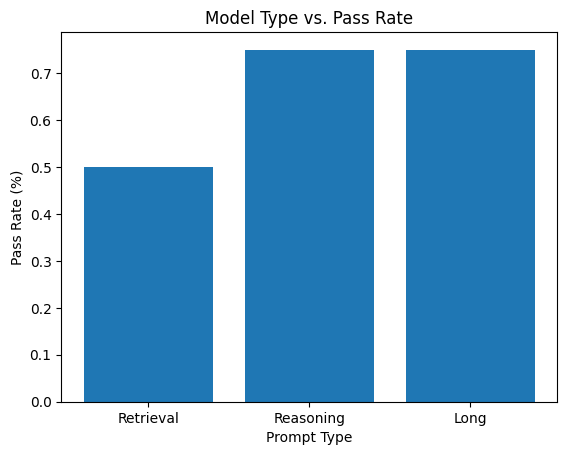

In [17]:
retrieval_pass_results = [0, 1, 0, 1]
reasoning_pass_results = [1, 1, 1, 0]
long_prompt_pass_results = [1, 1, 0, 1]

pass_rates = [ 
    sum(retrieval_pass_results)/len(retrieval_pass_results),
    sum(reasoning_pass_results)/len(reasoning_pass_results),
    sum(long_prompt_pass_results)/len(long_prompt_pass_results)
]

# Plotting
plt.bar(prompt_types, pass_rates)

# Adding labels and title
plt.xlabel('Prompt Type')
plt.ylabel('Pass Rate (%)')
plt.title('Model Type vs. Pass Rate')

# Show the plot
plt.show()